In [4]:
from cesium import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
eeg = datasets.fetch_andrzejak()

This data is from an electroencephalogram (EEG) data set, details can be found in this paper:
    <br>
https://perma.cc/YZD5-CTJF    
    <br>
EEG tracks and records brain wave patterns. The results of the test show changes in brain activity that may be useful in diagnosing brain conditions.

For this dataset, there are five categories of time series, all observations are equal length segments from:
 - EEG recordings of healthy people with eyes open
 - EEG recordings of healthy people with eyes closed
 - EEG recordings of epilepsy patients during seizure-free times from two non-seizure related areas of the brain
 - Another category of epilepsy patients from another area of the brain
 - EEG recording during a seizure
 
 Source: http://cesium-ml.org/docs/auto_examples/plot_EEG_Example.html#sphx-glr-auto-examples-plot-eeg-example-py
 
 We will follow these steps in the workflow:
  - Featurize the time series
  - Build classification models
  - Validate with test set

## Examine the data

Data is stored in a dictionary

In [3]:
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

In [4]:
# check out a sample of the data
print(eeg['times'][351])
print(eeg['measurements'][351])
print(eeg['classes'][351])

[0.00000000e+00 5.76171875e-03 1.15234375e-02 ... 2.35884766e+01
 2.35942383e+01 2.36000000e+01]
[-66. -70. -67. ... -21. -29. -36.]
F


In [5]:
# number of unique classes
np.unique(eeg['classes'])

array(['F', 'N', 'O', 'S', 'Z'], dtype='<U1')

Simplify the 5 classes into three: Normal, Interictal (between seizures) and Ictal (during a seizure).

In [6]:
# Group together classes (Z, O), (N, F), (S) as normal, interictal, ictal
eeg["classes"] = eeg["classes"].astype("U16") #  allocate memory for longer class names
eeg["classes"][np.logical_or(eeg["classes"]=="Z", eeg["classes"]=="O")] = "Normal"
eeg["classes"][np.logical_or(eeg["classes"]=="N", eeg["classes"]=="F")] = "Interictal"
eeg["classes"][eeg["classes"]=="S"] = "Ictal"



Plot a sample of a few EEG observations with their class labels

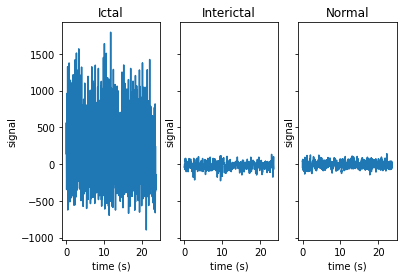

In [7]:
fig, ax = plt.subplots(1, len(np.unique(eeg["classes"])), sharey=True)
for label, subplot in zip(np.unique(eeg["classes"]), ax):
    i = np.where(eeg["classes"] == label)[0][0]
    subplot.plot(eeg["times"][i], eeg["measurements"][i])
    subplot.set(xlabel="time (s)", ylabel="signal", title=label)

## Featurize the time series

Cesium is a library in python that can help create features on time series data. It also has a web app that allows you to explore interactively with the ML pipelines  that you build. https://github.com/cesium-ml/cesium

Cesium can create a wide variety of features found here: http://cesium-ml.org/docs/feature_table.html

In [7]:
from cesium import featurize

features_to_use = ["amplitude", 
                   "percent_beyond_1_std",
                   "percent_close_to_median", 
                   "skew",
                   "max_slope"]
fset_cesium = featurize.featurize_time_series(times = eeg["times"],
                                                values = eeg["measurements"],
                                                errors = None,
                                                features_to_use = features_to_use,
                                                scheduler = None)

In [8]:
fset_cesium.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610
1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,171.5,0.300952,0.541128,0.063678,17008.813559
4,170.0,0.305101,0.566268,0.142753,13016.949153


The output of featurize_time_series is a dataframe which contains all the feature information that was created. This can be used to train an ML model. Feature names are the column names.

### Functions to build custom features

Custom functions that are not built into Cesium can be passed in using the custom_funtions keyword. These custom functions should take in three arrays as inputs (times, measurements, errors), these features are recommend by Guo et al. 2012: https://www.sciencedirect.com/science/article/abs/pii/S0957417411003253?via%3Dihub

In [9]:
import numpy as np
import scipy.stats

def mean_signal(t, m, e):
    return np.mean(m)

def std_signal(t, m, e):
    return np.std(m)

def mean_square_signal(t, m, e):
    return np.mean(m ** 2)

def abs_diffs_signal(t, m, e):
    return np.sum(np.abs(np.diff(m)))

def skew_signal(t, m, e):
    return scipy.stats.skew(m)

In [10]:
guo_features = {
    "mean": mean_signal,
    "std": std_signal,
    "mean2": mean_square_signal,
    "abs_diffs": abs_diffs_signal,
    "skew": skew_signal
}

fset_guo = featurize.featurize_time_series(times=eeg["times"], values=eeg["measurements"],
                                           errors=None,
                                           features_to_use=list(guo_features.keys()),
                                           custom_functions=guo_features)
print(fset_guo.head())

feature       mean        std        mean2 abs_diffs      skew
channel          0          0            0         0         0
0        -4.132048  40.411000  1650.122773   46948.0  0.032805
1       -52.444716  48.812668  5133.124725   61118.0 -0.092715
2        12.705150  47.144789  2384.051989   51269.0 -0.004100
3        -3.992433  47.072316  2231.742495   75014.0  0.063678
4       -17.999268  44.910958  2340.967781   52873.0  0.142753


In [12]:
# Combine the two sets of features
fullset = pd.concat([fset_cesium, fset_guo],axis =1)

In [13]:
fullset

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope,mean,std,mean2,abs_diffs,skew
channel,0,0,0,0,0,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610,-4.132048,40.411000,1650.122773,46948.0,0.032805
1,211.5,0.290212,0.640469,-0.092715,20653.559322,-52.444716,48.812668,5133.124725,61118.0,-0.092715
2,165.0,0.302660,0.515987,-0.004100,13537.627119,12.705150,47.144789,2384.051989,51269.0,-0.004100
3,171.5,0.300952,0.541128,0.063678,17008.813559,-3.992433,47.072316,2231.742495,75014.0,0.063678
4,170.0,0.305101,0.566268,0.142753,13016.949153,-17.999268,44.910958,2340.967781,52873.0,0.142753
...,...,...,...,...,...,...,...,...,...,...
495,876.5,0.368318,0.364413,-0.472757,94242.711864,12.870393,332.455418,110692.251892,251762.0,-0.472757
496,433.0,0.361728,0.394923,0.046880,27595.932203,7.087137,159.833074,25596.839151,163894.0,0.046880
497,1359.0,0.270442,0.628265,-0.468130,243156.610169,30.493532,374.077172,140863.586039,487670.0,-0.468130


## Model building

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb

In [17]:
eeg["classes"]

array(['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

In [14]:

X_train, X_test, y_train, y_test = train_test_split(fullset.values, eeg["classes"], random_state=21)

### KNN 

In [15]:
model_knn = KNeighborsClassifier(3)
model_knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

### Random forest

In [16]:

model_rf = RandomForestClassifier(n_estimators = 10,
                                max_depth = 3,
                                random_state = 21)
model_rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

### XGBoost

In [17]:
model_xgb = xgb.XGBClassifier(n_estimators = 10,
                                max_depth = 3,random_state = 21)
model_xgb.fit(X_train, y_train)


[14:26:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=21, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Prediction

In [18]:
from sklearn.metrics import accuracy_score

preds_knn_train = model_knn.predict(X_train)
preds_rf_train = model_rf.predict(X_train)
preds_xgb_train = model_xgb.predict(X_train)

preds_knn_test = model_knn.predict(X_test)
preds_rf_test = model_rf.predict(X_test)
preds_xgb_test = model_xgb.predict(X_test)

In [19]:
print("KNN(3) model: training accuracy={:.2%}, test accuracy={:.2%}".format(
          accuracy_score(preds_knn_train, y_train),
          accuracy_score(preds_knn_test, y_test)))
print("Random Forest model: training accuracy={:.2%}, test accuracy={:.2%}".format(
          accuracy_score(preds_rf_train, y_train),
          accuracy_score(preds_rf_test, y_test)))
print("XGBoost model: training accuracy={:.2%}, test accuracy={:.2%}".format(
          accuracy_score(preds_xgb_train, y_train),
          accuracy_score(preds_xgb_test, y_test)))

KNN(3) model: training accuracy=91.73%, test accuracy=91.20%
Random Forest model: training accuracy=87.47%, test accuracy=82.40%
XGBoost model: training accuracy=97.60%, test accuracy=96.80%
